# Introduction

In this notebook, I evaluate the order parameters for Bernal bilayer graphene (BBG). I calculate the order parameters within within mean field theory, and numerically solve the relevant self consistent field equations using an iterative approach. 

Once the order parameters have been solved, relevant physical observables, such as isospin occupation, are readily calculated and compared to expPeriment. 

I begin by importing the relevant libraries, and defining several global variables that will be used throughout.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

epsilon = 55.26349406/(1000*1000) #Dielectric Constant, in units of e^2*meV*nm
a = .246 #Lattice constant, in units of nm

L = 250*6 #Number of unit cells on one side of system
A = L**2*.052 #Total area of system, unit cell size times total copies of the unit cell 

u_calculated = a/(2*epsilon*A) #Bare interaction strength

u = u_calculated/10 #Interaction strength with screening

t = .005 #Temperature in units of meV, effectively T=0
d_gate = 200 #Distance from gate to graphene sample in units of nm

# Loading Results 

I load the results from the results of running the .py files. However, I need the momenta used in those files here as well, so I'll first define them the same way they are defined in solve_gap_refactored.py. 

In [3]:
b1 = np.array([2*np.pi,2*np.pi/np.sqrt(3)]) #Recipricol lattice vector 1
b2 = np.array([2*np.pi,-2*np.pi/np.sqrt(3)]) #Recipricol lattice vector 2
momenta = np.array([(n1*b1+n2*b2)/L for n1 in range(-200,200) for n2 in range(-200,200) if np.linalg.norm((n1*b1+n2*b2)/L)<4*np.pi/3*.06])
kx = momenta[:,0]
ky = momenta[:,1]

I load the results here. I choose the values for the order parameter, chemical potential, and isospin occupation that correspond to the state with the lowest energy. I then delete the results for the order parameter in states that do not minimize the energy, as this variable is by far the largest (4-8 GB), and will slow down performance if it remains in memory.

In [14]:
directory = 'results/' #Directory that hosts the results

#Loading each of the relevant parameters
energy = np.load(directory+'normal_state_bands.npy')
d = np.load(directory+'delta.npy')
ef = np.load(directory+'ef.npy')
ef_norm = np.load(directory+'ef_norm.npy')
errors = np.load(directory+'error.npy')
occupation = np.load(directory+'occupation.npy')
energies = np.load(directory+'best_energies.npy')

#Getting shapes of the displacement field, momenta, and number density arrays
lengthv = d.shape[0]
lengthn = d.shape[1]
lengthm = d.shape[4]

total_number = np.linspace(1e10,10e11,lengthn)
v = np.linspace(25,200,lengthv)

#Getting the order parameter, chemical potential, and isospin occupations that minimize the energy of the system
true_d = np.zeros((lengthv,lengthn,4,lengthm));
true_ef = np.zeros((lengthv,lengthn))
true_occupation = np.zeros((lengthv,lengthn,4))
for j in range(lengthv):
    for i in range(lengthn):
        true_d[j,i] = d[j,i,np.argmin(energies,axis=0)[j,i]]
        true_ef[j,i] = ef[j,i,np.argmin(energies,axis=0)[j,i]]
        true_occupation[j,i] = occupation[j,i,np.argmin(energies,axis=0)[j,i]]
        
true_occupation = np.moveaxis(np.array([true_occupation[:,:,i]/np.sum(true_occupation,axis=-1) for i in range(4)]),0,2)

del d

## Isospin Occupation

Here, the occupation of the majority isospin for both displamement field and number density is plotted. Then as an example, I plot all four isospin occupations for specific displacement field. This demonstrates some of the order phases that will appear in the system.

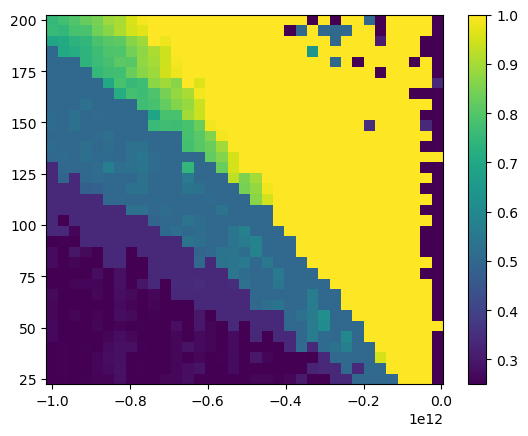

In [15]:
plt.colorbar(plt.pcolormesh(-total_number,v,np.sort(true_occupation)[:,:,-1]))

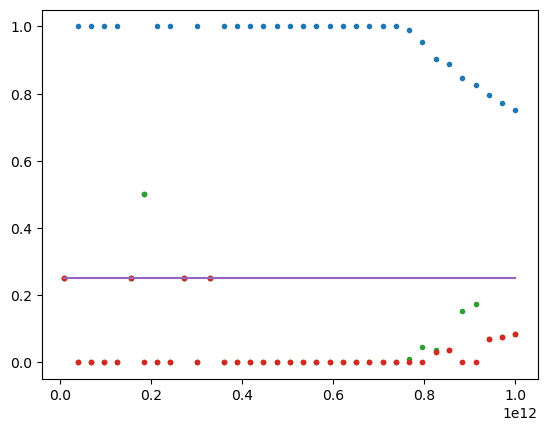

In [16]:
plt.plot(total_number,true_occupation[34],'.')
plt.plot(total_number,.25*np.ones(len(total_number)))

## Unique Phases

Now, I want to determine the unique phases in this system. This is determined by what fraction of particles are in each isospin. I categorize this, then determine all unique combinations of isospin occupations that occur. Then where these phases occur can be plotted. 

In [17]:
#Categorizing the isospin occupation
dummy = np.where(true_occupation<.01,0,true_occupation)
dummy = np.where((true_occupation>.01) & (true_occupation<.24),1,dummy)
dummy = np.where((true_occupation>.23) & (true_occupation<.26),2,dummy)
dummy = np.where((true_occupation>.26) & (true_occupation<.35),3,dummy)
dummy = np.where((true_occupation>.35) & (true_occupation<.54),4,dummy)
dummy = np.where((true_occupation>.52),5,dummy)
dummy = np.sort(dummy,axis=-1)

dummy2 = np.zeros((dummy.shape[0],dummy.shape[1],6))

#Getting the unique phases
for i in range(dummy.shape[0]):
    for j in range(dummy.shape[1]):
        test = dummy[i,j]
        zerolen = len(test[test==0])
        nonzero_unique = np.unique(test)[np.unique(test)!=0]
        nonzerolen = len(nonzero_unique)
        degeneracy = np.zeros(4)
        for k in range(nonzerolen):
            degeneracy[k] = len(test[test==nonzero_unique[k]])
        dummy2[i,j] = np.array([zerolen,nonzerolen,degeneracy[0],degeneracy[1],degeneracy[2],degeneracy[3]])

unique_values = np.unique(dummy2.reshape(-1,6),axis=0)
labels = np.linspace(0,len(unique_values)-1,len(unique_values))

#Replacing the original labels (which were numpy arrays) with numbers
labeled_states = np.array([[labels[(unique_values==x).all(axis=1)][0] for x in y] for y in dummy2])

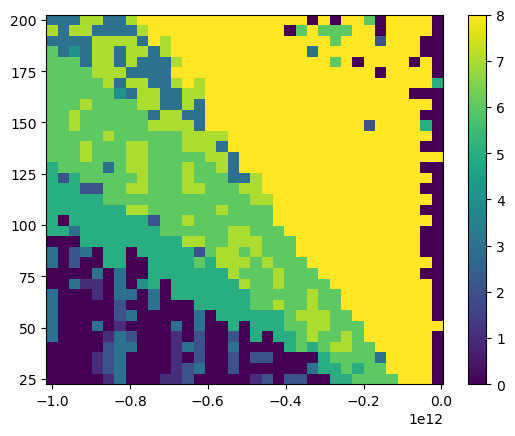

In [18]:
plt.colorbar(plt.pcolormesh(-total_number,v,labeled_states))

## Nematicity

A nematic state will break the $C_3$ symmetry present in the noninteracting Fermi surfaces of BBG. To measure if such a symmetry breaking occurs, I calculate the first cosine Fourier coefficient of the order parameter, then takes its ratio with the constant part. If the ratio is larger that .1, the $C_3$ symmetry is considered to be broken, and the state is nematic.

In [19]:
cos = np.nan_to_num(momenta[:,0]/np.linalg.norm(momenta,axis=-1))
total_int = np.abs(np.sum((true_d),axis=-1)*(momenta[1,0]-momenta[0,0])*((momenta[1,1]-momenta[0,1])))
total_int[total_int==0] = 1
nem = np.abs(np.sum((true_d*cos),axis=-1)*(momenta[1,0]-momenta[0,0])*((momenta[1,1]-momenta[0,1])))/total_int

/var/folders/1q/zp3790g13xl1ng295qgnlfdm0000gn/T/ipykernel_69513/44535051.py:1: RuntimeWarning: invalid value encountered in divide
  cos = np.nan_to_num(momenta[:,0]/np.linalg.norm(momenta,axis=-1))


I can then plot the Fermi surfaces of these nematic states to confirm they are not $C_3$ symmetric.

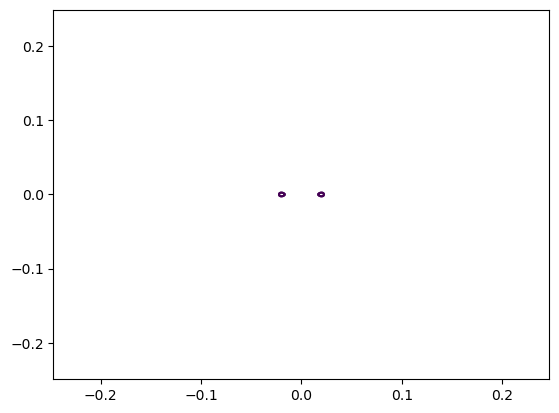

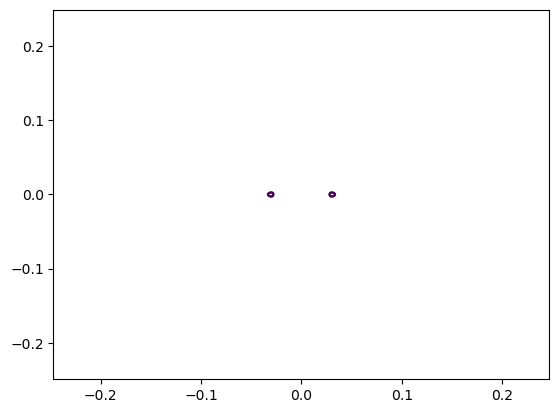

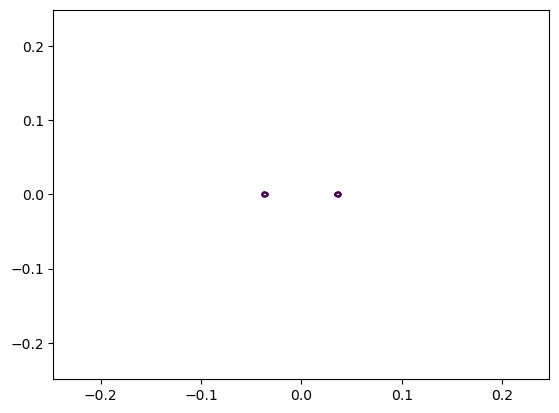

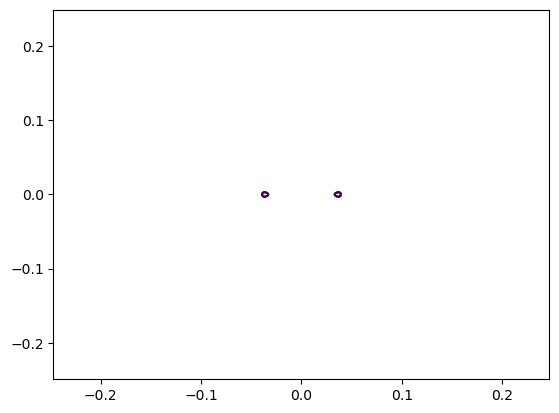

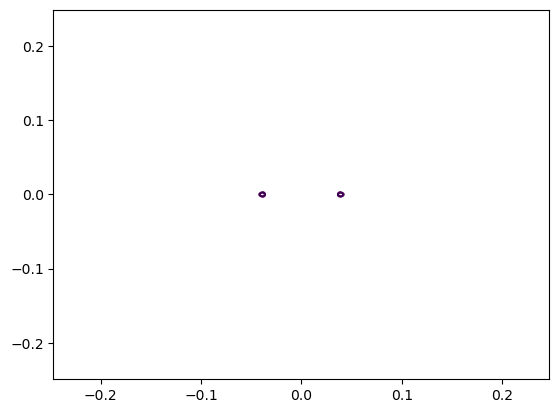

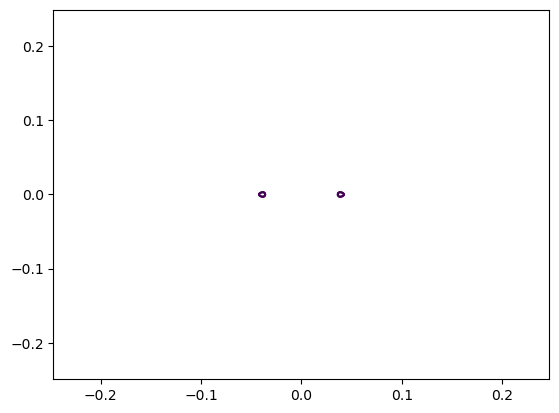

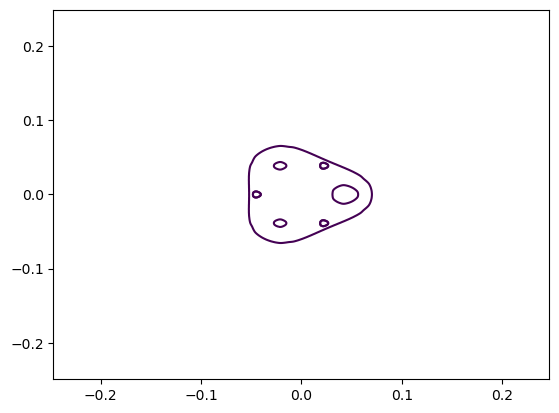

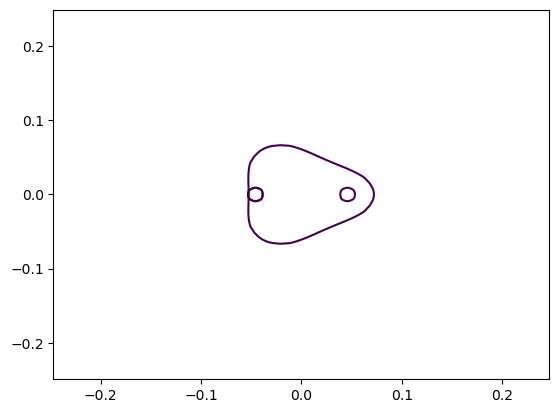

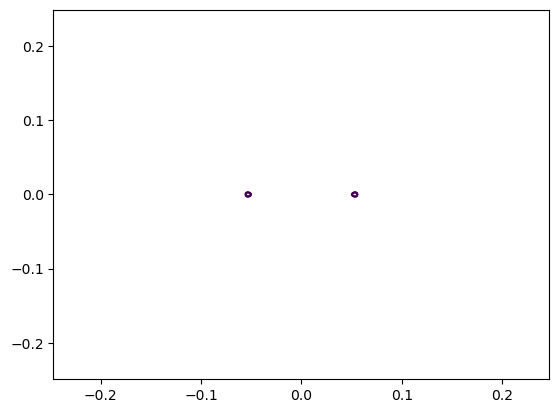

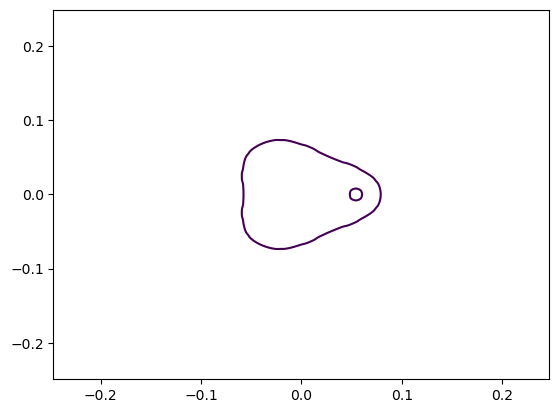

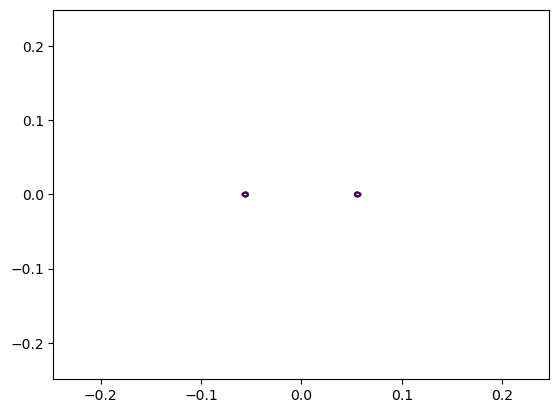

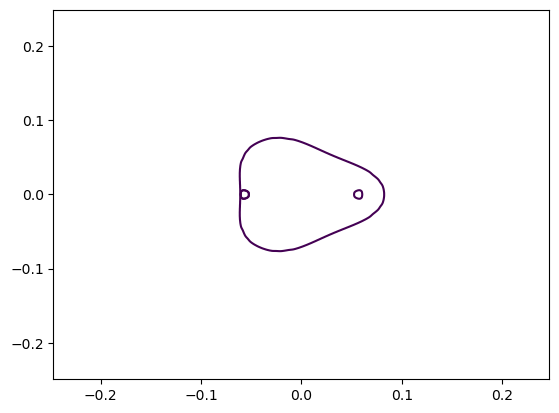

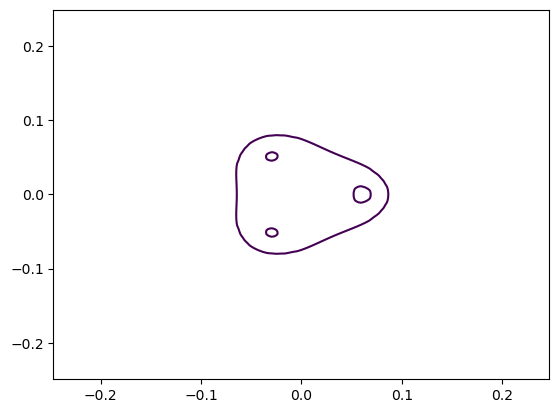

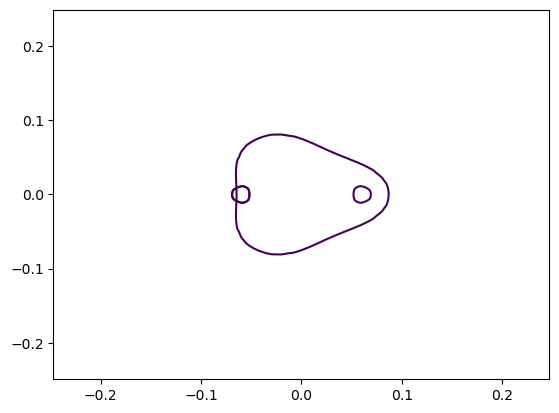

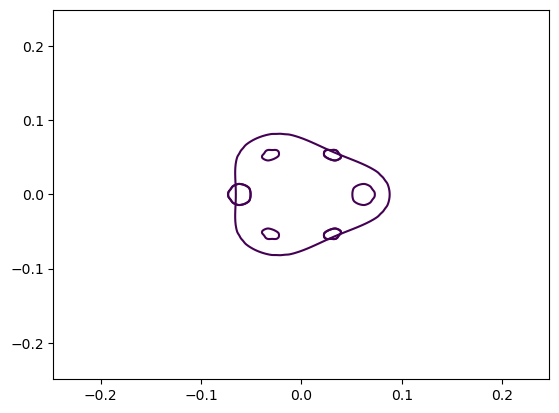

In [20]:
grid_x = np.linspace(kx.min(), kx.max(), 400)
grid_y = np.linspace(ky.min(), ky.max(), 400)
X, Y = np.meshgrid(grid_x, grid_y)

indices = np.unique(np.array([np.where(nem>.1)[0],np.where(nem>.1)[1]]).T,axis=0)

for index in indices:
    plt.figure()
    for e,x in zip(energy[:,index[0]],true_d[index[0],index[1]]):
        Z = griddata((kx, ky), e-x, (X, Y), method='cubic')
        plt.contour(X,Y,Z,[true_ef[index[0],index[1]]])

I can now plot where these nematic states occur on the same phase diagrams as before.

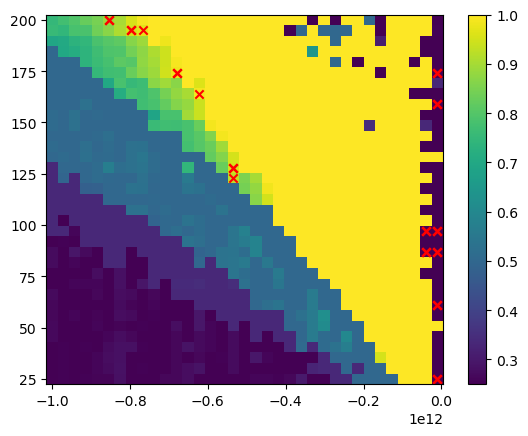

In [21]:
plt.colorbar(plt.pcolormesh(-total_number,v,np.sort(true_occupation)[:,:,-1]))
plt.scatter(-total_number[np.where(nem>.1)[1]],v[np.where(nem>.1)[0]],marker='x',color='red')

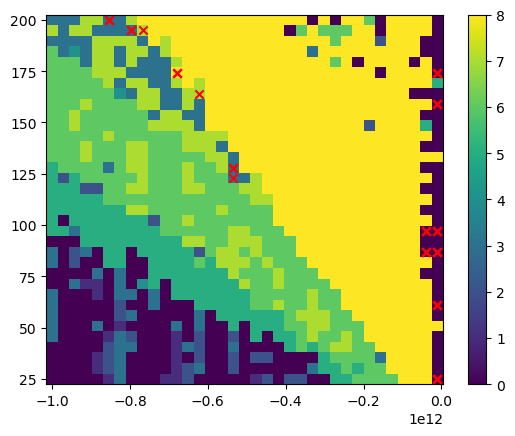

In [22]:
plt.colorbar(plt.pcolormesh(-total_number,v,labeled_states))
plt.scatter(-total_number[np.where(nem>.1)[1]],v[np.where(nem>.1)[0]],marker='x',color='red')